<a href="https://colab.research.google.com/github/pacesatuinineh/Gabor-Features/blob/main/Object01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import os
import pandas as pd
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
# Paths
data_path = "/content/drive/MyDrive/modifdataset"  # Adjust the path to where 'papua-1' and 'papua-2' are located



In [4]:
# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 100

In [5]:
# Preprocessing Function
def preprocess_image(image):
    # Resize image
    image = cv2.resize(image, IMAGE_SIZE)
    # Histogram equalization
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)
    # Apply noise reduction
    image = cv2.fastNlMeansDenoising(image, h=10)
    # Convert back to RGB
    return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

In [6]:
# Function to apply Haar wavelet transformation
def apply_haar_wavelet(image):
    I = image.astype(float)
    m, n = I.shape[:2]
    if m % 2 != 0:
        m -= 1
    if n % 2 != 0:
        n -= 1
    I = I[:m, :n]

    LL = np.zeros((m // 2, n // 2))
    for i in range(0, m, 2):
        for j in range(0, n, 2):
            Ixy = I[i:i + 2, j:j + 2]
            LL[i // 2, j // 2] = np.mean(Ixy)
    return LL

In [7]:
# Function to extract HOG features
def extract_hog_features(image):
    if len(image.shape) == 3:
        image = rgb2gray(image)
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

In [8]:
def load_data(path):
    data = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    # Preprocess image
                    image = preprocess_image(image)
                    # Apply Haar wavelet
                    haar_image = apply_haar_wavelet(image)
                    # Resize the image to 224x224 for ResNet50
                    haar_image = cv2.resize(haar_image, (224, 224))
                    # Extract HOG features
                    hog_features = extract_hog_features(image)
                    data.append(haar_image)  # Append the processed image
                    labels.append(folder)

    return np.array(data), np.array(labels)

In [9]:
# Load dataset
data, labels = load_data(data_path)

In [10]:
# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)


In [11]:
# Split into training and testing
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)


In [12]:
# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))


In [13]:
# Define CNN model with pretrained ResNet50
def build_model():
    input_tensor = Input(shape=(224, 224, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Tambahan lapisan
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(encoder.classes_), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze the top layers of the model
    for layer in base_model.layers[-50:]:
        layer.trainable = True

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [14]:
# Data augmentation
train_datagen = ImageDataGenerator(
    #rotation_range=40,
    #width_shift_range=0.5,
    #height_shift_range=0.5,
    #shear_range=0.5,
    #zoom_range=0.5,
    #horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    #fill_mode='nearest'
)

In [15]:
test_datagen = ImageDataGenerator()

In [16]:
# Load and preprocess images for CNN
def load_and_preprocess_images(path):
    images = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    image = preprocess_image(image)
                    images.append(image)
                    labels.append(folder)
    return np.array(images), np.array(labels)


In [17]:
train_images, train_labels = load_and_preprocess_images(data_path)
test_images, test_labels = load_and_preprocess_images(data_path)


In [18]:
# Encode labels
train_labels_encoded = encoder.fit_transform(train_labels)
test_labels_encoded = encoder.transform(test_labels)

train_labels_categorical = to_categorical(train_labels_encoded)
test_labels_categorical = to_categorical(test_labels_encoded)

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [19]:
# Fit the model
history = model.fit(
    train_datagen.flow(train_images, train_labels_categorical, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=test_datagen.flow(test_images, test_labels_categorical, batch_size=BATCH_SIZE),
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weight_dict
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.2171 - loss: 16.1584 - val_accuracy: 0.2584 - val_loss: 14.7110 - learning_rate: 1.0000e-04
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 361ms/step - accuracy: 0.2197 - loss: 15.4625 - val_accuracy: 0.2995 - val_loss: 14.4863 - learning_rate: 1.0000e-04
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.2844 - loss: 14.9128 - val_accuracy: 0.3458 - val_loss: 14.2665 - learning_rate: 1.0000e-04
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.3029 - loss: 14.5105 - val_accuracy: 0.3779 - val_loss: 14.0390 - learning_rate: 1.0000e-04
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.3303 - loss: 14.2608 - val_accuracy: 0.4042 - val_loss: 13.8046 - learning_rate: 1.0000e-04
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 376ms/step - accuracy: 0.3589 - loss: 13.9277 - val_accuracy: 0.4049 - val_loss: 13.6173 - learning_rate: 1.0000e-04
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step 

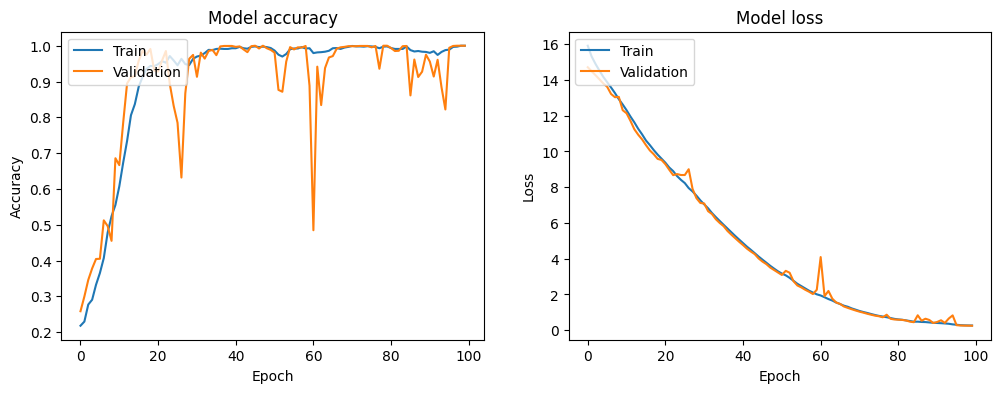

In [20]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()


49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step
              precision    recall  f1-score   support

     Aitinyo       1.00      1.00      1.00       374
     Ayamaru       1.00      1.00      1.00       311
      Kokoda       1.00      1.00      1.00       302
         Moi       1.00      1.00      1.00       330
       Tehit       1.00      1.00      1.00       239

    accuracy                           1.00      1556
   macro avg       1.00      1.00      1.00      1556
weighted avg       1.00      1.00      1.00      1556



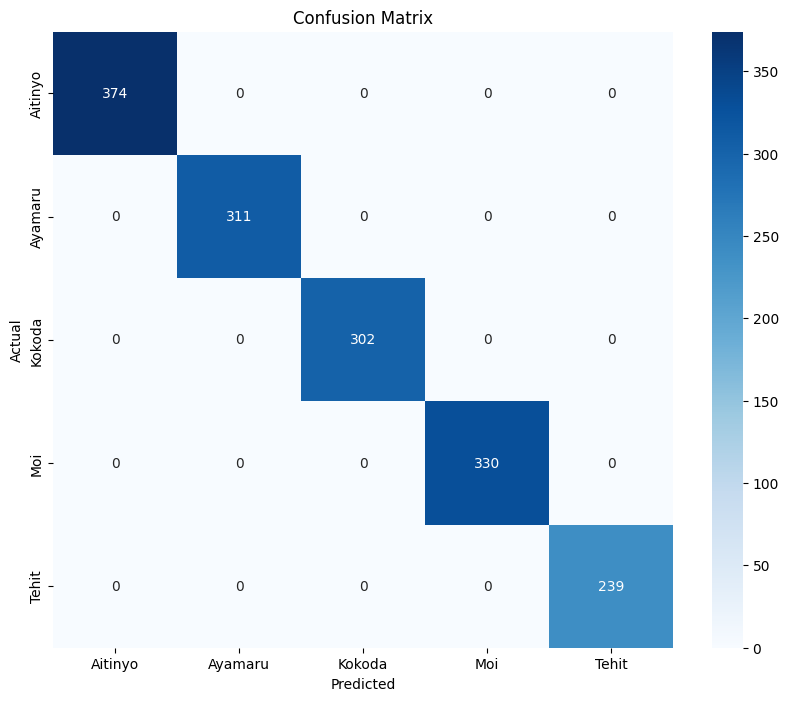

In [21]:
# Evaluate model
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Classification report and confusion matrix
print(classification_report(test_labels_encoded, predicted_classes, target_names=encoder.classes_))
cm = confusion_matrix(test_labels_encoded, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()